In [92]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [93]:
# Resnet 18
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [94]:
df = pd.read_csv("data/train_classes.csv")
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [95]:
all_tags = set()
for tags in df['tags'].str.split():
    all_tags.update(tags)

In [96]:
tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_tags))}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
print(tag_to_idx)
print(len(tag_to_idx))

{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
17


In [97]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        tags = self.df.iloc[idx, 1].split()
        labels = torch.zeros(len(tag_to_idx))
        for tag in tags:
            labels[tag_to_idx[tag]] = 1
        
        return image, labels

In [98]:
def visualize_sample(dataset, idx):
    image, labels = dataset[idx]
    
    # convert the image tensor to a PIL Image for display
    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image)
    
    # plot the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    
    # get the labels
    present_labels = [idx_to_tag[i] for i, label in enumerate(labels) if label == 1]
    
    # set the title with the labels
    plt.title(f"Labels: {', '.join(present_labels)}")
    plt.show()
    
    print(f"Image labels: {', '.join(present_labels)}")

In [99]:
dataset = MultiLabelImageDataset(csv_file="data/train_classes.csv", img_dir="data/train-jpg", transform=transform)

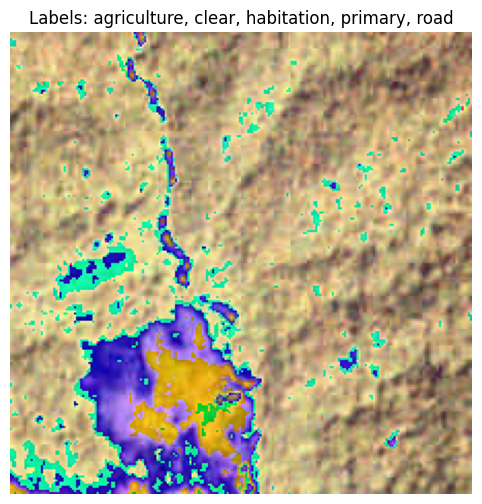

Image labels: agriculture, clear, habitation, primary, road


In [72]:
visualize_sample(dataset, 4)

In [101]:
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

In [102]:
batch_size = 64
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [103]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [104]:
import torchvision.models as models
from torch import nn

num_classes = 17

def ImageClassifier(num_classes):
    # Load a pre-trained model
    model = models.resnet34(pretrained=True)
    
    # Freeze all the parameters in the network
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the last fully connected layer
    # ResNet18 & 34 has 512 outputs in the last layer before classifier
    # ResNet50 has 2048 outputs in the last layer before classifier
    model.fc = nn.Linear(512, num_classes)
    
    return model

In [105]:
model = ImageClassifier(num_classes)
model.to(device)
model

/Users/hamsaraj/code/term7/cv/1d-proj/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hamsaraj/code/term7/cv/1d-proj/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [107]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 8 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, f1 = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # calculate f1 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.5
            true_tags = y.cpu().numpy()
            f1 += f1_score(true_tags, pred_tags, average='micro')

    test_loss /= num_batches
    f1 /= num_batches
    print(f"Test Error: \n F1 Score: {(100*f1):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [108]:
print(device)

mps


In [110]:
learning_rate = 0.01
epochs = 3

In [111]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.179349  [   64/40479]
loss: 0.154268  [  576/40479]
loss: 0.178442  [ 1088/40479]
loss: 0.166881  [ 1600/40479]
loss: 0.187684  [ 2112/40479]
loss: 0.152543  [ 2624/40479]
loss: 0.152661  [ 3136/40479]
loss: 0.172926  [ 3648/40479]
loss: 0.202388  [ 4160/40479]
loss: 0.192616  [ 4672/40479]
loss: 0.181434  [ 5184/40479]
loss: 0.163261  [ 5696/40479]
loss: 0.154983  [ 6208/40479]
loss: 0.165090  [ 6720/40479]
loss: 0.171155  [ 7232/40479]
loss: 0.155356  [ 7744/40479]
loss: 0.170099  [ 8256/40479]
loss: 0.148434  [ 8768/40479]
loss: 0.176820  [ 9280/40479]
loss: 0.170865  [ 9792/40479]
loss: 0.187215  [10304/40479]
loss: 0.170782  [10816/40479]
loss: 0.159742  [11328/40479]
loss: 0.195924  [11840/40479]
loss: 0.149899  [12352/40479]
loss: 0.189206  [12864/40479]
loss: 0.187128  [13376/40479]
loss: 0.176710  [13888/40479]
loss: 0.152760  [14400/40479]
loss: 0.182912  [14912/40479]
loss: 0.128001  [15424/40479]
loss: 0.198129  [15936/40479]


In [112]:
def predict_image(model, image_path, transform, idx_to_tag):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.sigmoid(outputs)
        predicted = probabilities > 0.5
        predicted_labels = [idx_to_tag[i] for i, pred in enumerate(predicted[0]) if pred]

    return predicted_labels, probabilities[0]

In [116]:
image_path = "data/test-jpg/test_5689.jpg"
predicted_labels, probabilities = predict_image(model, image_path, transform, idx_to_tag)

print("Predicted labels:", predicted_labels)
print("Probabilities:")
for i, prob in enumerate(probabilities):
    if prob > 0.5:
        print(f"{idx_to_tag[i]}: {prob.item():.4f}")

Predicted labels: ['clear', 'habitation', 'primary', 'road']
Probabilities:
clear: 0.7293
habitation: 0.7571
primary: 0.9229
road: 0.8371
